# **GEOM90006: Spatial Data Analytics – Assignment 4**
##### **Group: G49**
##### Takamasa Oshiro: 1626510, Shriya Krishna Kumar: 1418627, Ankita Holey: 1621609
##### Lecturer: A/Prof. Jagannath Aryal


# Understanding the Spatial Relationship of 1-in-100 Year Flood Extent and the Distribution of Dams and Retarding Basins in Moira, Victoria

##  Project Topic

This project focuses on identifying spatial patterns in flood-prone areas and analyzing how natural and man-made systems—like flow accumulation, elevation, dams, and retarding basins—interact to influence flood risks in Moira, Victoria.

---

##  Research Questions

- What are the patterns of the distribution of 1-in-100 year flood extent in Moira, Victoria?
- What is the relationship between the scale of 1-in-100 year flood extent and the distribution of dams and retarding basins in Moira, Victoria?
- How does flow accumulation in Moira affect the distribution of 1-in-100 year flood extent?

---

##  Project Scope

This project investigates the spatial patterns of 1-in-100 year flood extents in the Moira region of Victoria, with a focus on understanding how these flood-prone areas relate to the distribution of dams and retarding basins, and how natural flow accumulation affects these patterns. The aim is to gain insight into where flood risks are most concentrated, how infrastructure aligns with those risks, and how water movement across the landscape contributes to flood extent. To explore these themes, we use a combination of vector and raster geospatial analysis. The study applies both point-level and aggregated spatial analysis, including Local Government Area (LGA) and regional scales, to provide a comprehensive view of the spatial dynamics of flood risk and infrastructure coverage.

---

##  Introduction

Global warming has led to more intense and irregular rainfall patterns across Australia. In Victoria, these climatic shifts are increasing the likelihood of extreme flooding events, particularly during seasonal peak periods. Studies show rising trends in short-duration rainfall and greater accumulation of rain over a few days, leading to flash floods and river overflow. At the same time, dams and retarding basins are critical for flood management—temporarily storing water and reducing peak discharge. However, while both flooding and mitigation strategies are well-studied individually, there is a gap in spatial analysis examining how infrastructure and hydrological features like flow accumulation interact across local geographies.

This project bridges that gap by spatially analyzing how elevation, slope, rainfall, and flow accumulation relate to the 1-in-100 year flood extent in Moira. It also evaluates whether flood mitigation infrastructure is well-positioned in high-risk zones. The results will help assess whether the physical and engineered systems in Moira are aligned with actual flood vulnerabilities.


## Data Sources

| Dataset                            | Description                                                   | Common Source / Provider                                   |
|------------------------------------|---------------------------------------------------------------|------------------------------------------------------------|
| Flow accumulation raster           | Derived from a Digital Elevation Model (DEM); shows where water accumulates naturally |https://elevation.fsdf.org.au/, https://pro.arcgis.com/ |
| 1-in-100 year flood extent points  | Historical flood locations representing rare, extreme events  | https://data.gov.au/data/dataset/ , https://data.vic.gov.au/ |
| Moira LGA boundary                 | Administrative boundary of the Moira local government area    |  https://data.vic.gov.au/                         |
| Victoria state shapefile           | Polygon boundary of the entire state of Victoria              |  https://data.vic.gov.au/    |
| Dams and retarding basins data     | Locations and attributes of water retention structures        |  https://data.vic.gov.au/          |
| Rainfall Data                      | Historical rainfall records| Bureau of Meteorology (BoM)     |


## Data Loading & Preprocessing

In [1]:
##Imports 
import geopandas as gpd
import numpy as np
import pandas as pd
import math

from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import sobel
from scipy.spatial import distance_matrix
import geopandas as gpd
import rasterio
import rasterio.features
import rasterio.crs
import rasterio.warp
from rasterio.mask import mask
from rasterio.features import geometry_mask
import rioxarray as rxr
import richdem as rd
from rasterio.warp import calculate_default_transform, reproject, Resampling
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from skgstat import Variogram
from scipy.spatial import cKDTree
from libpysal.weights import KNN
from esda import Moran, Moran_Local
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pysal.viz import splot
from splot.esda import plot_moran
import contextily
from splot import esda as esdaplot
from pysal.lib import weights
from numpy.random import seed
from pysal.explore import esda
import seaborn


def load_and_prepare_data(vic_shp, moira_shp, vic_rainfall, flood_extent_moira, moira_dem, dam):
    # Load shapefiles
    vic = gpd.read_file(vic_shp)
    moira = gpd.read_file(moira_shp).to_crs("EPSG:4326")
    
    # Load rainfall data
    rainfall_df = pd.read_csv(vic_rainfall)
    
    # Load flood extent
    flood = gpd.read_file(flood_extent_moira)
    dams = gpd.read_file(dam)
    
    # Open DEM raster and sample flow accumulation values
    with rasterio.open(moira_dem) as src:
        acc_data = src.read(1, masked=True)
        acc_crs = src.crs
        acc_transform = src.transform
        acc_nodata = src.nodata
        
        # Reproject vector data to raster CRS
        flood = flood.to_crs(acc_crs)
        moira = moira.to_crs(acc_crs)
        
        coords = [(geom.x, geom.y) for geom in flood.geometry]
        sampled_values = list(src.sample(coords))
        flood["accum_value"] = [
            val[0] if val[0] != acc_nodata else np.nan for val in sampled_values
        ]
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    
    return vic, moira, rainfall_df, flood, acc_data, acc_crs, acc_transform, acc_nodata, extent, dams

## defining datasets
vic_shp = "data/vic-data/victoria_state.shp"
moira_shp = "data/Moira_LGA.shp"
vic_rainfall = "data/rainfall.2022-2025_vic.csv"
flood_extent_moira = "data/1-in-100_flood_extent_Moira_projectedxy.geojson"
moira_dem = "data/Moira_using_coords.tif"
dam = 'data/moira_dam_basin.geojson'

vic, moira, rainfall_df, flood, acc_data, acc_crs, acc_transform, acc_nodata, extent, dams = load_and_prepare_data(
    vic_shp, moira_shp, vic_rainfall, flood_extent_moira, moira_dem, dam
)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/anaconda3/envs/spanalytics/lib/python3.11/site-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


##  Study Area: Moira, Victoria
Moira is a local government area in northern Victoria, Australia. This section shows the Moira boundary within the context of the state of Victoria.

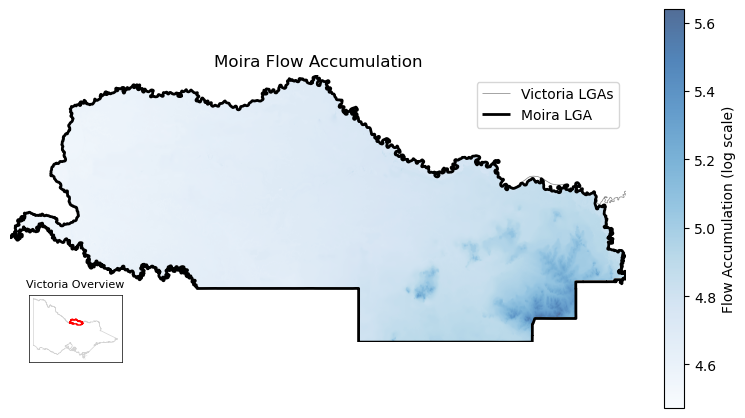

In [2]:

# Set up plot
fig, ax = plt.subplots(figsize=(8, 6))
# Step 1: Load and mask raster to Moira
with rasterio.open(moira_dem) as src:
    moira_geom = [moira.geometry.iloc[0]]
    out_image, out_transform = mask(src, moira_geom, crop=True)
    out_image = out_image[0]
    out_image[out_image <= 0] = np.nan
    flow_log = np.log1p(out_image)

    # Step 2: Plot raster
    img = ax.imshow(
        flow_log, cmap="Blues", alpha=0.7,
        extent=[
            out_transform[2],
            out_transform[2] + out_transform[0] * flow_log.shape[1],
            out_transform[5] + out_transform[4] * flow_log.shape[0],
            out_transform[5]
        ]
    )
    plt.colorbar(img, ax=ax, label="Flow Accumulation (log scale)", shrink=0.7)

# Plot Victoria LGAs in light gray
vic.boundary.plot(ax=ax, color="gray", linewidth=0.5, label="Victoria LGAs")
#  Plot Moira on top in red
moira.boundary.plot(ax=ax, color="black", linewidth=2, label="Moira LGA")
ax.set_xlim(moira.total_bounds[0], moira.total_bounds[2])
ax.set_ylim(moira.total_bounds[1], moira.total_bounds[3])
ax.set_title("Moira Flow Accumulation")
ax.legend()
plt.axis("off")
plt.tight_layout()

ax_inset = inset_axes(
    ax,
    width="25%", height="25%",         
    loc="lower left",                  
    bbox_to_anchor=(-0.03, -0.1, 1, 1),     
    bbox_transform=ax.transAxes 
)
# Plot full Victoria and Moira for overview
vic.boundary.plot(ax=ax_inset, color="lightgray", linewidth=0.5)
moira.boundary.plot(ax=ax_inset, color="red", linewidth=1)
ax_inset.set_xticks([])
ax_inset.set_yticks([])
ax_inset.set_title("Victoria Overview", fontsize=8)
for spine in ax_inset.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(0.5)

plt.show()

# 1. What are the patterns of the distribution of 1-in-100 year flood extent in Moira, Victoria?

## Kernel Density Estimate (KDE)

### Method
The KDE is to demostrate a skewed distribution of local Moran's I statistics. The scale values of 1-in-100 flood extent data was used in the KDE.

### Results & Discussion

The curve as shown in the below KDE graph shows two peaks of the density. One is the highest density of about 0.7, while the another is the density of about 0.35. The spatial association of the graph is positive. These findings indicate that the scale values of local statistics are positive and similar in space. Moreover, it could be mentioned that a high value is surrounded by high values, or a low value is surrouded by low values. The first case is called HH, while the second case is called LL. However, the KDE graph does not identify HH and LL.

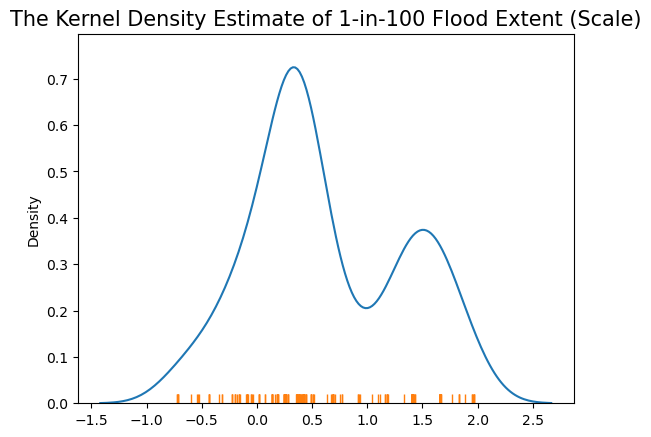

In [3]:
# transform the victoria_state.shp to EPSG: 7855
moira_gdf7855 = gpd.read_file(moira_shp).to_crs(7855)
flood = gpd.read_file(flood_extent_moira)

w = weights.KNN.from_dataframe(flood, k = 10)
w.transform = "R"

lisa = esda.moran.Moran_Local(flood['SCALE'], w)
ax = seaborn.kdeplot(lisa.Is)
ax.set_title ('The Kernel Density Estimate of 1-in-100 Flood Extent (Scale)', fontsize = 15)
seaborn.rugplot(lisa.Is, ax = ax);

## Local Indicators of Spatial Association (LISAs)

### Method

LISAs are known as Local Moran's I. LISAs demonstrate the distribution of the values on a area with identifying positive and negative values of local statistics, HH, LL, LH, HL, significant and non-significant, and clusters of significant HH, LL, LH, HL. The 1-in-100 flood extent data and Moira polygon data were used in LISAs.

### Results & Discussion

There are four maps as shown after codes. The top-left map (Local Association Positive/Negative) shows the distribution of positive and negative local statistic values of the 1-in-100 flood extent data with ranges of -0.72 - 0.13 (Blue), 0.13 - 0.37 (Purple), 0.37 - 0.51 (Pink), 0.51 - 1.41 (Orange), and 1.41 - 1.97 (Yellow) in Moira. The orange points are mainly located in the middle area of Moira and the north-eastern boundary of Moira. Similarly, blue and purple points are concentrated in the middle area, while pink poionts are near the north-eastern boundary. The yellow points ara mainly located in the southern area of Moira. As mentioned about the KDE map previously, the map similarly demonstrates the posive and negative values and additionlly visualizes them with the distribution of them in Moira. 

The top-right map (Local Moran's I) shows HH, HL, LH, LL of local statistic values of  the 1-in-100 flood extent data. The distribution of HH is mainly in the middle area of and the southern area of Moira, while LL are mainly distributed in the middle area of and the north-eastern boundary of Moira. HL and LH are similarly distributed in the middle area of Moira: however, one cluster of HL is located in the middle-west area of Moira. These clusters of HH, HL, LH, LL indicate that there is the potential pattern of the distribution of the scale values of the data.

The bottom-left map (Statistical Significance) shows singnificant (brown) and non-significant (light blue) p-values of the points in Moira. The light blue points are concentrated in the middle area of Moira, while brown points are distributed in the western, eastern and southern areas of Moira. These findings indicate that the scale values of 1-in-100 floods are not randomly distributed across Moira.

The bottom-right map (Local Moran's I Cluster Map) shows significant HH, HL, LH, and LL, and non-significant points. The distribution of HH, HL, LH, LL is same as the top-right map. The key feature of the bottom-right map is the distribution of HH, HL, LH, and LL including significance as refered to the outcomes of the bottom-left map. Therefore, it could be mentioned that HH, HL, LH, and LL are not randomly distributed. The clusters of them imply that the high scale values of 1-in-100 floods are distributed in the middle area of and the sourtern area of Moira, while the low scale values of 1-in-100 floods are distributed in the middle area of and the north-eastern boundary of Moira. Moreover, spatial association between HH and LL is positive, which in turn shows the probability of the positive local spatial autocorrelation in the scale values of 1-in-100 floods.

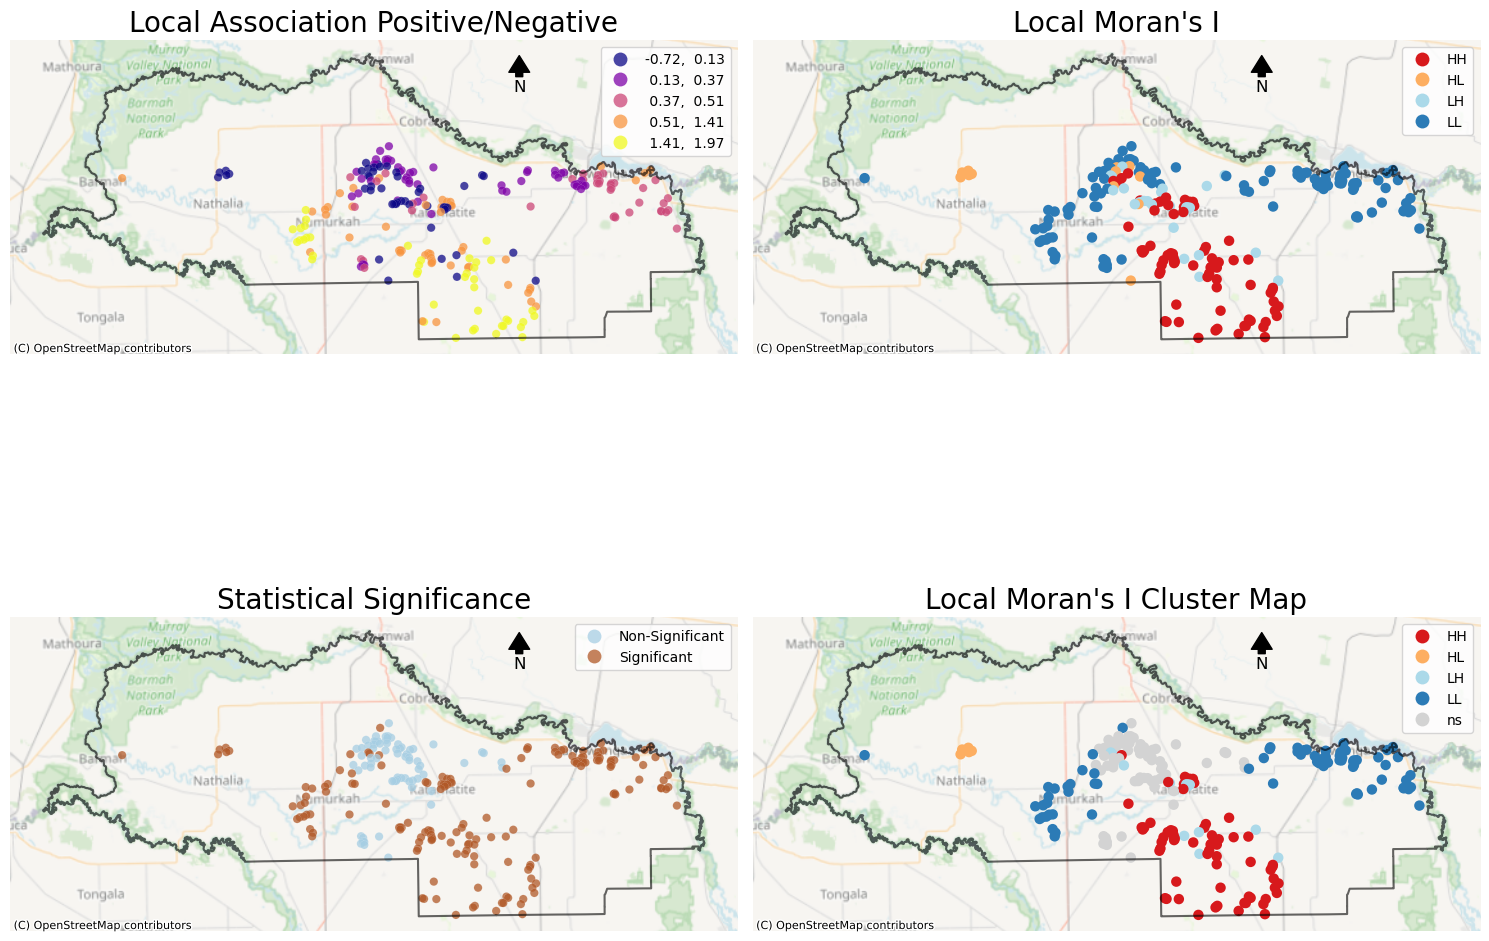

In [4]:
f, axs = plt.subplots (nrows = 2, ncols = 2, figsize = (15, 14))

axs = axs.flatten()

ax = axs [0]
flood.assign (
    Is = lisa.Is
).plot (
    column = 'Is',
    cmap = 'plasma',
    scheme = 'quantiles',
    k = 5,
    edgecolor = 'white',
    linewidth = 0.1,
    alpha = 0.75,
    legend = True,
    ax = ax,
)
moira_gdf7855.plot (ax = ax, facecolor = 'none', edgecolor = 'k', linewidth = 1.5, alpha = 0.6)
ax.axis ('on')
contextily.add_basemap (ax, crs = flood.crs.to_string(), alpha = 0.6, source = contextily.providers.OpenStreetMap.
                       Mapnik)
ax.annotate ('N', xy = (0.7, 0.95), xytext = (0.7, 0.85),
            arrowprops = dict (facecolor ='black', width = 5, headwidth = 15),
            ha = 'center', va ='center', fontsize = 12, xycoords=ax.transAxes)

ax = axs [1]
esdaplot.lisa_cluster (lisa, flood, p=1, ax=ax)

moira_gdf7855.plot (ax = ax, facecolor = 'none', edgecolor = 'k', linewidth = 1.5, alpha = 0.6)

ax.axis ('on')
contextily.add_basemap (ax, crs = flood.crs.to_string(), alpha = 0.6, source = contextily.providers.OpenStreetMap.
                       Mapnik)
ax.annotate ('N', xy = (0.7, 0.95), xytext = (0.7, 0.85),
            arrowprops = dict (facecolor ='black', width = 5, headwidth = 15),
            ha = 'center', va ='center', fontsize = 12, xycoords=ax.transAxes)


ax = axs [2]
labels = pd.Series (
    1 * (lisa.p_sim < 0.05),
    index = flood.index,
).map ({1: "Significant", 0: "Non-Significant"},)

flood.assign (
    cl = labels
).plot (
    column = 'cl',
    categorical = True,
    cmap = 'Paired',
    k = 2,
    edgecolor = 'white',
    linewidth = 0.1,
    alpha = 0.75,
    legend = True,
    ax = ax,
)
moira_gdf7855.plot (ax = ax, facecolor = 'none', edgecolor = 'k', linewidth = 1.5, alpha = 0.6)
contextily.add_basemap (ax, crs = flood.crs.to_string(), alpha = 0.6, source = contextily.providers.OpenStreetMap.
                       Mapnik)
ax.annotate ('N', xy = (0.7, 0.95), xytext = (0.7, 0.85),
            arrowprops = dict (facecolor ='black', width = 5, headwidth = 15),
            ha = 'center', va ='center', fontsize = 12, xycoords=ax.transAxes)

ax = axs [3]

esdaplot.lisa_cluster (lisa, flood, p = 0.05, ax = ax, figsize = 30)
moira_gdf7855.plot (ax = ax, facecolor = 'none', edgecolor = 'k', linewidth = 1.5, alpha = 0.6,)
ax.axis ('on')
contextily.add_basemap (ax, crs = flood.crs.to_string(), alpha = 0.6, source = contextily.providers.OpenStreetMap.
                       Mapnik)
ax.annotate ('N', xy = (0.7, 0.95), xytext = (0.7, 0.85),
            arrowprops = dict (facecolor ='black', width = 5, headwidth = 15),
            ha = 'center', va ='center', fontsize = 12, xycoords=ax.transAxes)

for i, ax in enumerate (axs.flatten()):
    ax.set_axis_off()
    ax.set_title (
        [
            "Local Association Positive/Negative",
            "Local Moran's I",
            "Statistical Significance",
            "Local Moran's I Cluster Map", 
        ] [i],
        y = 1, fontsize = 20
    )

f.tight_layout()
plt.show()

# 2. How does flow accumulation in Moira affect the distribution of 1-in-100 year flood extent?

This section explores how flow accumulation affects the distribution of 1-in-100 year flood extent in Moira, Victoria. Understanding this relationship helps in managing flood risk and planning infrastructure.

 **Exploratory Spatial Data Analysis (ESDA)**

- To begin understanding the spatial dynamics of flooding in Moira, we performed an exploratory spatial data analysis (ESDA).  
  This involved loading and visualizing core datasets including flow accumulation rasters and flood extent shapefiles. Through map visualizations and initial overlays, we explored patterns in elevation and flow convergence that correspond with 1-in-100 year flood zones. Summary statistics and visual inspections helped identify key relationships and guided the choice of methods for further analysis.


### **Methods:**

- **IDW Interpolation**  
  We use **Inverse Distance Weighting (IDW)** as an initial approach to visualize estimated flow accumulation patterns based on observed flood points, helping to reveal general spatial trends in water convergence. This method gives a preliminary view of whether flood events cluster in certain areas.

- **DEM-Based Flow Accumulation**  
  Flow accumulation is calculated from a **Digital Elevation Model (DEM)**. This method helps determine whether areas of high flow accumulation align with known flood extents, suggesting terrain-driven flood risks.
  *Reference*: Bhuyan, K., & Sarma, J. N. (2019). Flood risk zonation of the Dikrong basin using geospatial techniques. *Applied Water Science, 9*(4), 1–15. https://doi.org/10.1007/s13201-019-0955-7

- **Spatial Correlation Analysis using Variogram**  
  Spatial Correlation Analysis is done using a **variogram**, which helps confirm whether nearby areas have similar flow accumulation values—indicating reliable and structured terrain-driven hydrological behavior.
  *Reference*: Tarboton, D. G. (1997). A new method for the determination of flow directions and upslope areas in grid digital elevation models. *Water Resources Research, 33*(2), 309–319. https://doi.org/10.1029/96WR03137
    Western, A. W., Grayson, R. B., & Green, D. G. (1999). The Tarrawarra project: High-resolution spatial measurement, modelling and analysis of soil moisture and hydrological processes. *Journal of Hydrology, 217*(1–2), 213–233. https://doi.org/10.1016/S0022-1694(98)00255-5


#### Statistical Analysis - Raster-based Flow Accumulation Summary

In [5]:
flood_poly=flood
# Reproject flood polygons to match raster CRS
flood_poly = flood_poly.to_crs(acc_crs)
# Create binary mask where True = inside flood polygon
flood_mask = geometry_mask(
    [geom for geom in flood_poly.geometry],
    transform=acc_transform,
    invert=True,
    out_shape=acc_data.shape
)
# Extract accumulation values from inside and outside flood zones
acc_inside = acc_data[flood_mask]
acc_outside = acc_data[~flood_mask]
# Remove nodata/masked values
acc_inside = acc_inside[~acc_inside.mask]
acc_outside = acc_outside[~acc_outside.mask]
# Compute summary statistics
stats = {
    "Mean Accumulation (Flood Zone)": round(np.mean(acc_inside), 2),
    "Max Accumulation (Flood Zone)": round(np.max(acc_inside), 2),
    "Mean Accumulation (Non-Flood Zone)": round(np.mean(acc_outside), 2),
    "Max Accumulation (Non-Flood Zone)": round(np.max(acc_outside), 2),
}
# Identify top 10% accumulation threshold
threshold_90 = np.percentile(acc_data.compressed(), 90)
# Calculate percentage of flood zone pixels above 90th percentile
high_acc_flood = acc_inside[acc_inside > threshold_90]
pct_high_acc = round((len(high_acc_flood) / len(acc_inside)) * 100, 2)
# Add to output
stats["Flow Accum Threshold (90th Percentile)"] = round(threshold_90, 2)
stats["% Flood Zone Pixels > 90th Percentile"] = pct_high_acc
# Show results
for key, val in stats.items():
    print(f"{key}: {val}")

Mean Accumulation (Flood Zone): 118.49
Max Accumulation (Flood Zone): 182.0399932861328
Mean Accumulation (Non-Flood Zone): 116.27
Max Accumulation (Non-Flood Zone): 404.2900085449219
Flow Accum Threshold (90th Percentile): 137.03
% Flood Zone Pixels > 90th Percentile: 2.64


##### Results and Discussion
**Interpretation**
*The flow accumulation data shows how much water naturally gathers at different spots in the Moira region. The average flow accumulation inside flood zones is 118.49, while outside it’s 116.27 – a very small difference.The maximum flow accumulation outside flood zones (404.29) is much higher than inside (182.04), suggesting some major water pathways lie beyond mapped flood zones. We found that areas affected by major flooding have only slightly higher average water accumulation than areas that didn’t flood, only about 2.6% of the flood zone lies in the highest flow areas, which means that most floods happen in places with moderate, not extreme, water flow.*

#### Spatial Interpolation (IDW)

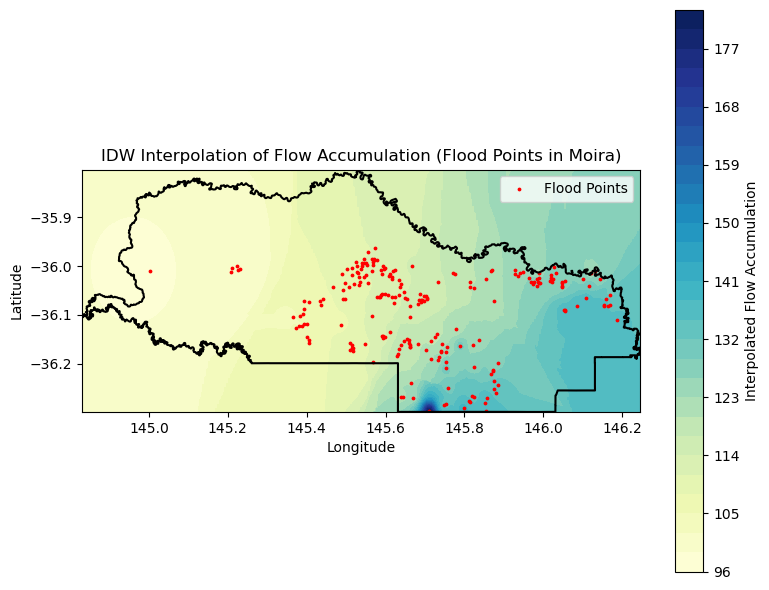

In [6]:
# IDW interpolation of flow accumulation surface
#  Extract points and flow accumulation values
with rasterio.open(moira_dem) as src:
        acc_data = src.read(1, masked=True)
        acc_crs = src.crs
        acc_transform = src.transform
        acc_nodata = src.nodata
        
        # Reproject vector data to raster CRS
        flood = flood.to_crs(acc_crs)
        moira = moira.to_crs(acc_crs)
        
        coords = [(geom.x, geom.y) for geom in flood.geometry]
        sampled_values = list(src.sample(coords))
        flood["accum_value"] = [
            val[0] if val[0] != acc_nodata else np.nan for val in sampled_values
        ]
points = np.array([(geom.x, geom.y) for geom in flood.geometry])
values = flood["accum_value"].values

#  Define grid over Moira extent
minx, miny, maxx, maxy = moira.total_bounds
grid_x, grid_y = np.meshgrid(
    np.linspace(minx, maxx, 300),
    np.linspace(miny, maxy, 300)
)
grid_points = np.vstack((grid_x.ravel(), grid_y.ravel())).T

# IDW function
def idw(xy, z, xi, power=2):
    tree = cKDTree(xy)
    dists, idxs = tree.query(xi, k=8, p=2)
    weights = 1.0 / np.power(dists, power)
    weights[dists == 0] = 1e12  # prevent divide-by-zero
    z_idw = np.sum(weights * z[idxs], axis=1) / np.sum(weights, axis=1)
    return z_idw

# 5. Perform IDW with power=2
grid_z = idw(points, values, grid_points, power=2).reshape(grid_x.shape)

# 6. Plot
fig, ax = plt.subplots(figsize=(8, 6))
cf = ax.contourf(grid_x, grid_y, grid_z, levels=30, cmap='YlGnBu')
flood.plot(ax=ax, color='red', markersize=3, label='Flood Points')
moira.boundary.plot(ax=ax, color='black')
plt.colorbar(cf, label='Interpolated Flow Accumulation')
ax.set_title('IDW Interpolation of Flow Accumulation (Flood Points in Moira)')
ax.legend()
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

##### Results and Discussion
**Internpretation**
*This map is an IDW iterpolation to shows how water tends to collect in different areas of Moira, based on flood points. The colored background is an estimate—yellow areas collect less water, while green to blue areas collect more. Most of the red flood points fall where water builds up, showing that water accumulation likely contributes to flooding.*

#### Flow Accumulation Analysis 

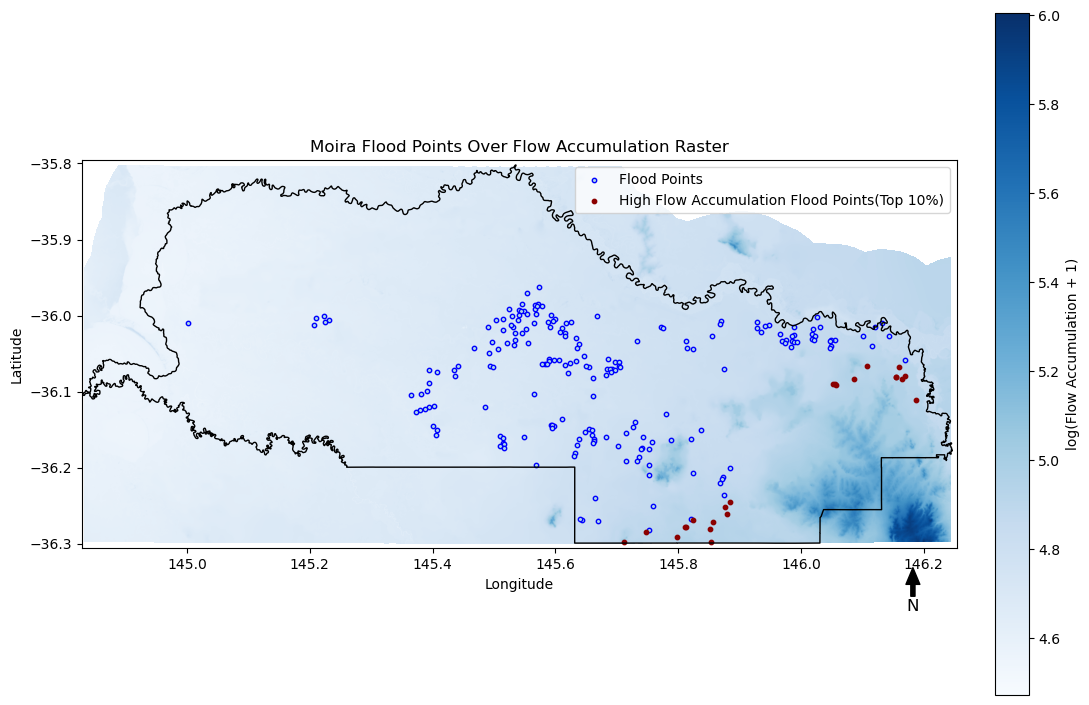

In [7]:
# Determine high-flow threshold
threshold = np.percentile(flood["accum_value"].dropna(), 90)
high_flow_points = flood[flood["accum_value"] >= threshold]
low_flow_points = flood[flood["accum_value"] < threshold]

# Plot setup
fig, ax = plt.subplots(figsize=(11, 8))
im = ax.imshow(np.log1p(acc_data), extent=extent, cmap="Blues", origin="upper")

# Add Moira LGA boundary
moira.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# Add flood points
low_flow_points.plot(ax=ax, color="lightblue", edgecolor="blue", markersize=10, label="Flood Points")
high_flow_points.plot(ax=ax, color="darkred", markersize=10, label="High Flow Accumulation Flood Points(Top 10%)")

# North arrow
ax.annotate('N', xy=(0.95, -0.05), xytext=(0.95, -0.15),
            arrowprops=dict(facecolor='black', width=3, headwidth=10),
            ha='center', va='center', fontsize=12,
            xycoords='axes fraction')


# Labels and legend
ax.set_title("Moira Flood Points Over Flow Accumulation Raster")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend(loc="upper right")
cbar = plt.colorbar(im, ax=ax, fraction=0.036, pad=0.04)
cbar.set_label("log(Flow Accumulation + 1)")

plt.tight_layout()
plt.show()


##### Results and Discussion
**Interpretation**
*This map shows how areas with heavy water flow relate to flood-prone locations in the Moira region. Darker blue zones on the left represent places where rainwater naturally gathers and flows. On the right, blue circles show where major floodshave occurred or are predicted. The dark red dots highlight flood points that lie in the top 10% of high-flow areas. The map reveals that while some flooding occurs in these major flow paths, most flood locations actually lie outside them — suggesting that factors beyond just water accumulation (like elevation, slope, land use, or rainfall patterns) may also contribute to flooding in Moira.*

### Terrain Analysis using DEM

This section explores how terrain features like elevation and slope may influence water flow and flood occurrence in Moira.

#### DEM Elevation Map

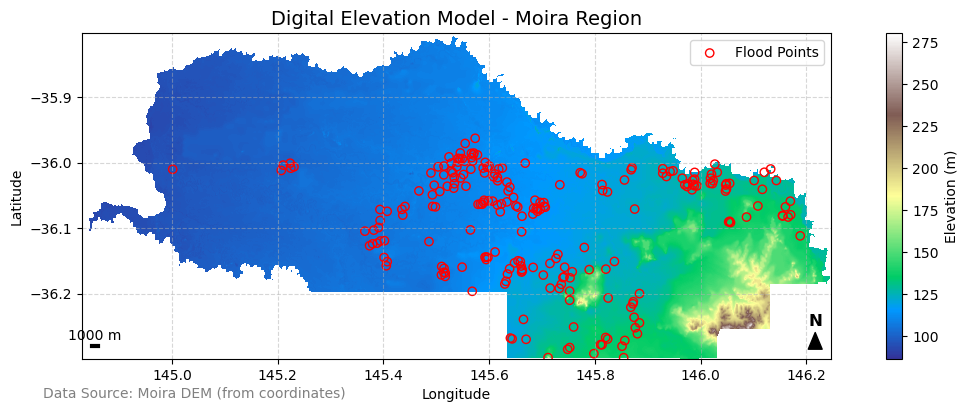

In [8]:

# Load DEM
dem = rxr.open_rasterio(moira_dem, masked=True).squeeze()

# Clip DEM to Moira boundary
dem_moira = dem.rio.clip(moira.geometry.values, moira.crs, drop=True)

# Extract bounds and aspect ratio
xmin, ymin, xmax, ymax = dem_moira.rio.bounds()
extent = [xmin, xmax, ymin, ymax]
aspect_ratio = (ymax - ymin) / (xmax - xmin)

# Create plot
fig, ax = plt.subplots(figsize=(12, 12 * aspect_ratio))
img = ax.imshow(dem_moira.values, cmap='terrain', extent=extent, origin='upper')
cbar = fig.colorbar(img, ax=ax, label='Elevation (m)')

# Optional: overlay flood extent
try:
    flood = gpd.read_file(flood_extent_moira).to_crs(moira.crs)
    flood.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1, label="Flood Points")
    ax.legend()
except Exception as e:
    print("Flood extent not shown:", e)

# Title
ax.set_title("Digital Elevation Model - Moira Region", fontsize=14)

# Scale bar (approx 1000 meters in degrees)
scalebar_length = 0.01  # degrees ~1000m
scalebar_x = xmin + 0.02
scalebar_y = ymin + 0.02
ax.plot([scalebar_x, scalebar_x + scalebar_length], [scalebar_y, scalebar_y], color='black', lw=3)
ax.text(scalebar_x + scalebar_length / 2, scalebar_y + 0.005, '1000 m',
        ha='center', va='bottom', fontsize=10)

# North arrow
arrow_x = xmax - 0.03
arrow_y = ymin + 0.03
ax.annotate('', xy=(arrow_x, arrow_y + 0.01), xytext=(arrow_x, arrow_y),
            arrowprops=dict(facecolor='black', width=4, headwidth=10))
ax.text(arrow_x, arrow_y + 0.015, 'N', fontsize=12, ha='center', va='bottom', fontweight='bold')

# Attribution
# Add data source text below the map
plt.annotate(
    "Data Source: Moira DEM (from coordinates)", 
    xy=(0.15, -0.12), 
    xycoords='axes fraction',
    ha='center', fontsize=10, color='gray'
)


# Axis labels and grid
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


##### Results and Discussion
**Interpretation**
*This map shows the elevation of the Moira region using color—from low (blue) to high (brown)—with red circles marking where major floods (1-in-100 year events) have occurred. We can clearly see that most flood points fall in the lower-elevation areas (shaded blue and green), especially in the center and east. This supports our research question: lower elevation areas in Moira tend to collect more water, which increases flow accumulation and the risk of flooding. So, elevation plays a key role in shaping how water builds up and causes floods in specific zones.*

#### Slope Calculation

In [9]:
transform = dem.rio.transform()
crs = dem.rio.crs
dem_array = dem.values

# Calculate slope (in degrees)
dzdx = sobel(dem_array, axis=1, mode='constant') / transform[0]
dzdy = sobel(dem_array, axis=0, mode='constant') / transform[4]
slope_array = np.arctan(np.sqrt(dzdx**2 + dzdy**2)) * 180 / np.pi

# Use rasterio to sample slope at flood locations
with rasterio.open(moira_dem) as src:
    profile = src.profile
    profile.update(dtype='float32', count=1)
    
    # Write slope to a temporary in-memory raster
    with rasterio.io.MemoryFile() as memfile:
        with memfile.open(**profile) as slope_ds:
            slope_ds.write(slope_array.astype('float32'), 1)
            coords = [(geom.x, geom.y) for geom in flood.geometry]
            samples = list(slope_ds.sample(coords))
            flood['slope_deg'] = [s[0] if s[0] != src.nodata else np.nan for s in samples]

# Preview updated GeoDataFrame
print(flood[["geometry", "slope_deg"]].head())

                      geometry  slope_deg
0  POINT (145.61116 -36.13620)  89.966370
1  POINT (145.72997 -36.13968)  89.944611
2  POINT (145.40128 -36.14460)  89.972672
3  POINT (145.59219 -36.14410)  89.500671
4  POINT (145.59762 -36.14447)  89.959534



A Slope calculation (degrees)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.42671                         ] (42% - 2.0s - 1 threads)


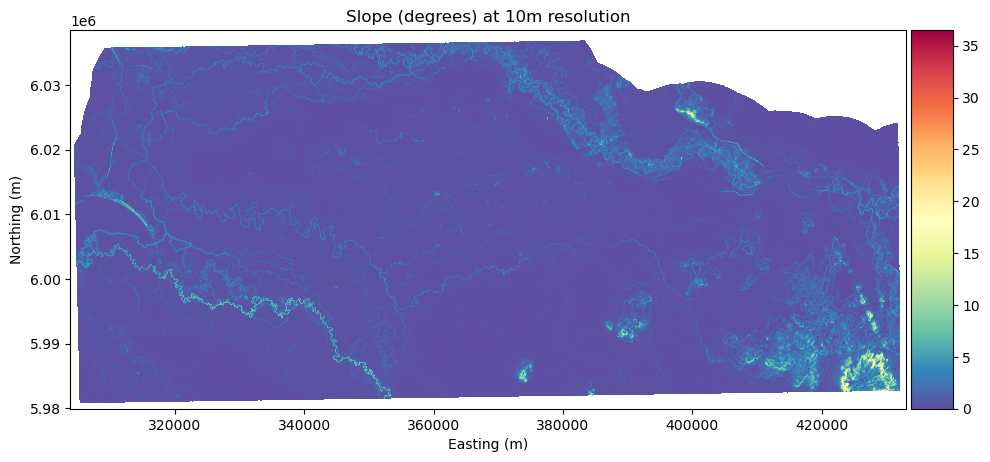

In [10]:

#  Reproject DEM to metric CRS
with rasterio.open(moira_dem) as src:
    transform, width, height = calculate_default_transform(
        src.crs, "EPSG:7855", src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': 'EPSG:7855',
        'transform': transform,
        'width': width,
        'height': height
    })

    reprojected_path = "data/moira_dem_7855.tif"
    with rasterio.open(reprojected_path, 'w', **kwargs) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs="EPSG:7855",
            resampling=Resampling.bilinear)

#  Read reprojected DEM
with rasterio.open(reprojected_path) as ds:
    arr = ds.read(1).astype(float)
    arr[arr == ds.nodata] = np.nan
    res = ds.res[0]  # resolution in meters
    bounds = ds.bounds

# Compute slope
dem_rd = rd.rdarray(arr, no_data=np.nan)
dem_rd.geotransform = (0, res, 0, 0, 0, -res)
slope = rd.TerrainAttribute(dem_rd, attrib='slope_degrees')

#  Plot
fig, ax = plt.subplots(figsize=(10, 8))
extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
im = ax.imshow(slope, cmap='Spectral_r', extent=extent)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax, orientation='vertical')
ax.set_title("Slope (degrees) at 10m resolution")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
plt.tight_layout()
plt.show()

##### Results and Discussion
**Interpretation**
*This slope map shows how steep or flat the land is in Moira. The blue and purple areas are the flattest parts, and the yellow and red spots are steeper. Flat land doesn't let water flow away quickly, so it collects there more easily. That’s why floods are more likely to happen in these flat areas. By looking at this map along with flow accumulation and flood data, we can see that places where the land is flat and water builds up are the same places that tend to flood. So, slope helps explain where and why flooding happens in Moira.*

#### Spatial Correlation Analysis-Variogram of Flow Accumulation

/opt/anaconda3/envs/spanalytics/lib/python3.11/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


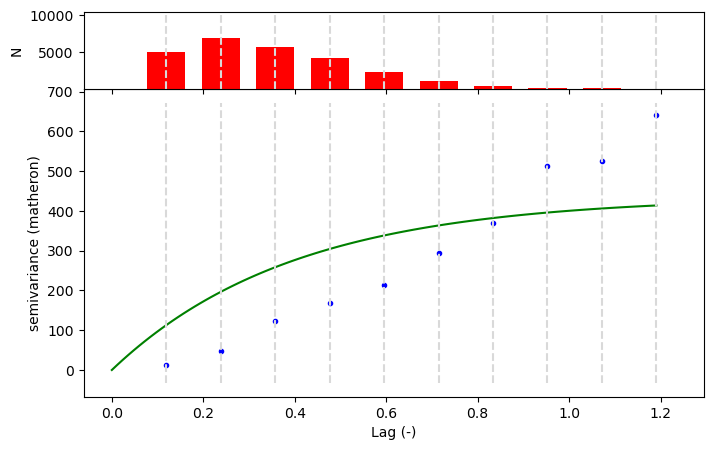

In [11]:
with rasterio.open(moira_dem) as src:
    acc_data = src.read(1, masked=True)
    acc_crs = src.crs
    acc_transform = src.transform
    acc_nodata = src.nodata
    flood = flood.to_crs(acc_crs)
    moira = moira.to_crs(acc_crs)
    coords = [(geom.x, geom.y) for geom in flood.geometry]
    sampled_values = list(src.sample(coords))
    flood["accum_value"] = [val[0] if val[0] != src.nodata else np.nan for val in sampled_values]
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
# Flatten and store values
flood["accum_value"] = [val[0] if val[0] != src.nodata else np.nan for val in sampled_values]
coords = np.array([(geom.x, geom.y) for geom in flood.geometry])
values = flood["accum_value"].values
valid = ~np.isnan(values)
coords = coords[valid]
values = values[valid]
V = Variogram(coords, values, model='exponential')
fig = V.plot() 

##### Results and Discussion
**Interpretation**
*This variogram graph shows that flow accumulation in Moira is spatially correlated—meaning nearby locations tend to have similar flow accumulation values. As the distance between points increases, their flow accumulation differences grow, up to a point where the relationship levels off, indicating that distant areas no longer influence each other. This pattern confirms that flow accumulation behaves consistently over space and supports its use in predicting flood extent.*

### Elevation vs. Flood and Slope vs. Flood

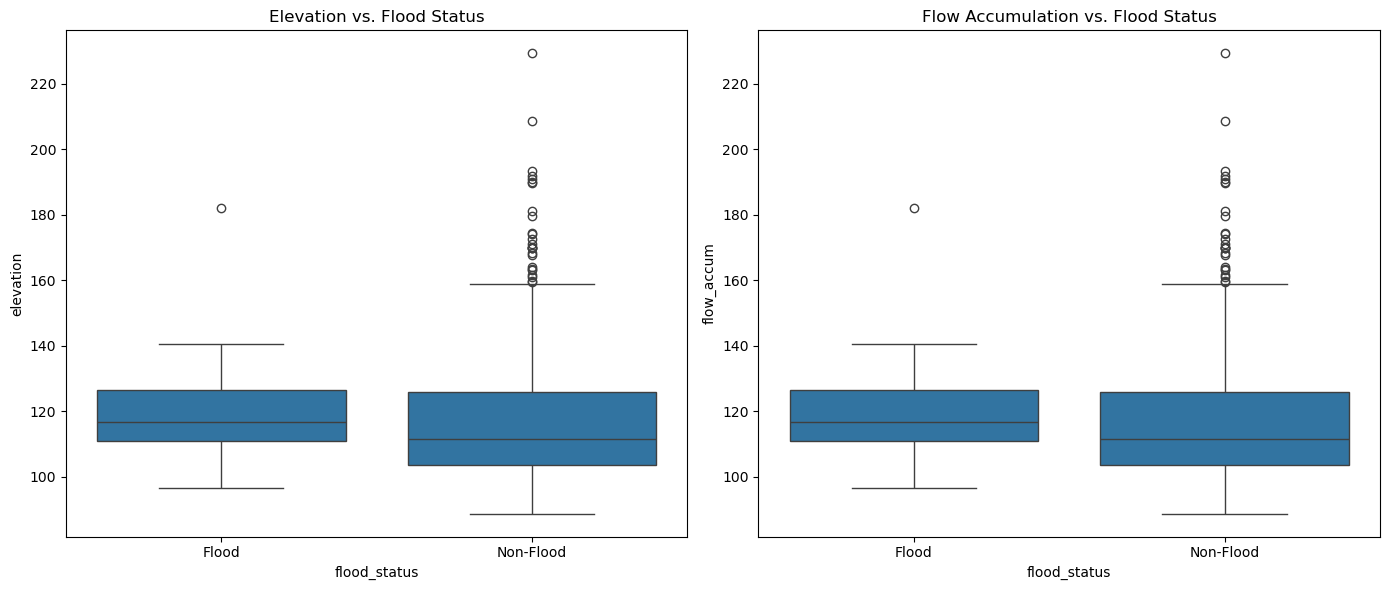

In [12]:
flood["flood_status"] = "Flood"
# Generate random non-flood points in Moira
moira = moira.to_crs(acc_crs)
bounds = moira.total_bounds
xs = np.random.uniform(bounds[0], bounds[2], 1000)
ys = np.random.uniform(bounds[1], bounds[3], 1000)
rand_points = gpd.GeoDataFrame(geometry=[Point(x, y) for x, y in zip(xs, ys)], crs=acc_crs)
rand_points = rand_points[rand_points.within(moira.unary_union)]
rand_points["flood_status"] = "Non-Flood"

# Combine and sample values
all_points = pd.concat([flood[["geometry", "flood_status"]], rand_points])
with rasterio.open(moira_dem) as src:
    coords = [(pt.x, pt.y) for pt in all_points.geometry]
    values = list(src.sample(coords))
    all_points["elevation"] = [v[0] if v[0] != acc_nodata else np.nan for v in values]
    all_points["flow_accum"] = [v[0] if v[0] != acc_nodata else np.nan for v in values]

# Drop any rows with missing data
all_points.dropna(inplace=True)

# Boxplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.boxplot(data=all_points, x="flood_status", y="elevation", ax=axs[0])
axs[0].set_title("Elevation vs. Flood Status")
sns.boxplot(data=all_points, x="flood_status", y="flow_accum", ax=axs[1])
axs[1].set_title("Flow Accumulation vs. Flood Status")
plt.tight_layout()
plt.show()

#### Results and Discussion
**Interpretation**
These two boxplots show the difference in elevation and flow accumulation between areas that experienced flooding and those that didn’t.

Left plot (Elevation): On average, flooded areas tend to be slightly lower in elevation than non-flooded areas.Non-flood areas include more high elevation outliers, suggesting they are at higher ground and less prone to flooding.

Right plot (Flow Accumulation): Flooded areas also generally show higher flow accumulation values, meaning more water flows into these spots. This pattern suggests that higher water buildup is associated with a greater likelihood of flooding.


## Conclusion
 By combining terrain data (elevation and slope) and hydrological flow accumulation, we found that floods are more likely to occur in flatter, lower-elevation areas where water tends to collect. Visual maps and statistical comparisons showed that many flood-affected areas overlap with zones of high flow accumulation. The analysis suggests a link between areas of high flow accumulation and flood extent. Understanding these patterns is key for flood management and planning. 

*Assumptions, Strengths, or Potential errors:*
- **Assumptions**: Flow follows terrain; ignores rainfall, land use, and urban infrastructure.
- **Strengths**: Using Multi-method approach helped with terrain-informed analysis and clear visual outputs.
- **Limitations**: DEM quality affects accuracy, and other flood drivers not modeled.

# 3. What is the relationship between the scale of 1-in-100 year flood extent and the distribution of dams and retarding basins in Moira, Victoria?

## ESDA
### Method
**ESDA to hypothesize relationship between flood events and dam insfrastructure: **
We first reprojected our flood event and dam geometries (and the study area LGA) into a common projected CRS (EPSG:28354) to ensure accurate metric calculations. For each flood point, we then computed the minimum Euclidean distance to the nearest dam and summarized these distances both statistically and with a histogram. To assess local dam availability, we generated 1 km buffers around each flood and calculated dam counts and densities (per square metre) within those buffers. Finally, we tested for spatial autocorrelation in dam density using Global Moran’s I (with an 8 nearest neighbours weight matrix) and mapped significant local clusters (High High and Low Low) via Local Moran’s I (LISA) to identify hotspots and coldspots of dam presence relative to flood occurrence. 

Flood points count: 227
Dams & basins count: 22
count      227.000000
mean     10537.596581
std       6081.961965
min        471.773285
25%       5460.768043
50%      10944.267183
75%      14022.086669
max      41648.947940
Name: nearest_dam_dist, dtype: float64


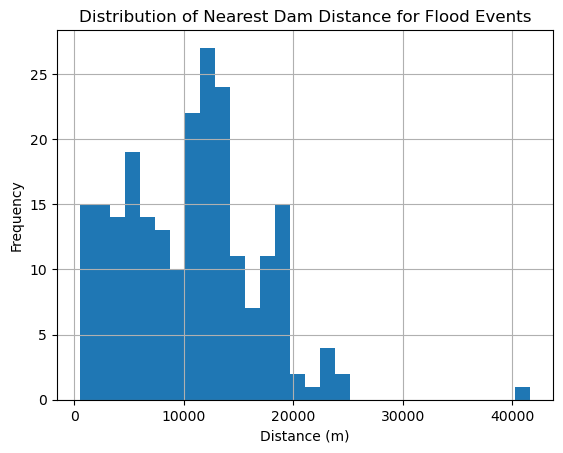

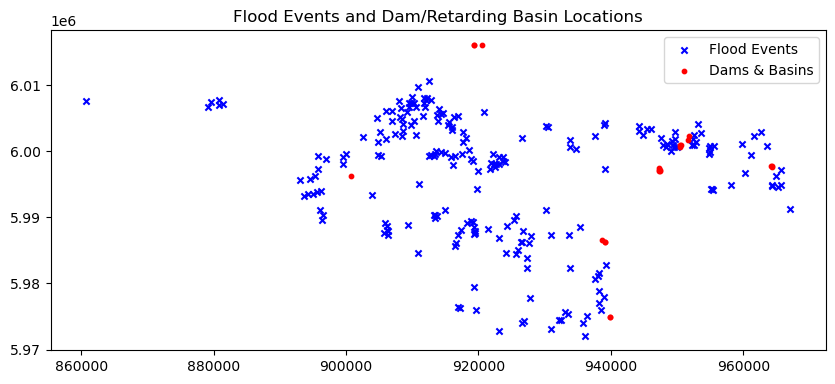

       dam_count_1km  dam_density_1km
count     227.000000     2.270000e+02
mean        0.035242     1.121794e-08
std         0.279997     8.912571e-08
min         0.000000     0.000000e+00
25%         0.000000     0.000000e+00
50%         0.000000     0.000000e+00
75%         0.000000     0.000000e+00
max         3.000000     9.549274e-07
Global Moran's I: 0.1386, p-value: 0.0000


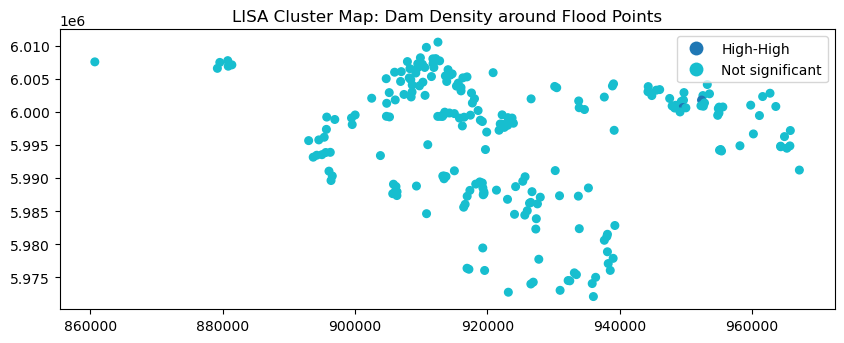

In [13]:
#defining the data loads 

flood = flood.to_crs("EPSG:28354")
dams  = dams.to_crs("EPSG:28354")
lga   = moira.to_crs(  "EPSG:28354")

#quick ESDA: summary stats 
print("Flood points count:", len(flood))
print("Dams & basins count:", len(dams))

flood_gdf = flood
dams_gdf = dams

# Compute nearest dam distance for each flood location
def nearest_distance(point, others):
    return others.distance(point).min()

flood_gdf['nearest_dam_dist'] = flood_gdf.geometry.apply(
    lambda pt: nearest_distance(pt, dams_gdf.geometry)
)
print(flood_gdf['nearest_dam_dist'].describe())

# Histogram of nearest-dam distances
flood_gdf['nearest_dam_dist'].hist(bins=30)
plt.title('Distribution of Nearest Dam Distance for Flood Events')
plt.xlabel('Distance (m)')
plt.ylabel('Frequency')
plt.show()

# Map: flood vs dams
fig, ax = plt.subplots(figsize=(10, 10))
flood_gdf.plot(ax=ax, marker='x', color='blue', markersize=20, label='Flood Events')
dams_gdf.plot(ax=ax, marker='o', color='red', markersize=10, label='Dams & Basins')
ax.set_title('Flood Events and Dam/Retarding Basin Locations')
ax.legend()
plt.show()

# Point pattern: dam density around each flood (1 km buffer)
buffer_dist = 1000  # metres
flood_gdf['dam_count_1km'] = flood_gdf.geometry.buffer(buffer_dist).apply(
    lambda geom: dams_gdf.geometry.within(geom).sum()
)
area_circle = 3.1416 * buffer_dist**2
flood_gdf['dam_density_1km'] = flood_gdf['dam_count_1km'] / area_circle
print(flood_gdf[['dam_count_1km','dam_density_1km']].describe())

# Spatial autocorrelation (Global Moran's I)
coords = list(zip(flood_gdf.geometry.x, flood_gdf.geometry.y))
w = KNN.from_array(coords, k=8)
y = flood_gdf['dam_density_1km'].values
mi = Moran(y, w)
print(f"Global Moran's I: {mi.I:.4f}, p-value: {mi.p_norm:.4f}")

# Local Moran (LISA) for dam density
lisa = Moran_Local(y, w)
flood_gdf['lisa_q'] = lisa.q
flood_gdf['lisa_p'] = lisa.p_sim
flood_gdf['cluster'] = 'Not significant'
flood_gdf.loc[(lisa.q == 1) & (lisa.p_sim < 0.05), 'cluster'] = 'High-High'
flood_gdf.loc[(lisa.q == 3) & (lisa.p_sim < 0.05), 'cluster'] = 'Low-Low'

# Map LISA clusters
fig, ax = plt.subplots(figsize=(10, 10))
flood_gdf.plot(column='cluster', categorical=True, legend=True,
               markersize=30, ax=ax)
ax.set_title('LISA Cluster Map: Dam Density around Flood Points')
plt.show()

### Results and Discussion

ESDA Interpretation: 
- ESDA of Flood–Dam Proximity
Nearest‐dam distance: Median ≈ 10.9 km (50% of flood points lie within ~11 km of the closest dam)
25 % ≤ 5.5 km, 75 % ≤ 14 km, but a few events sit > 20 km away
A few outliers at around 40 km
for dam count within 1 km, mean is  0.035 dams (i.e. nearly 0)
75 % of the floods have 0 dams in their 1 km buffer. We see that max of 3 dams in 1 km
Implication here is that most flood events occur where local dam density is extremely low.

- Global and Local Moran’s I
Global Moran’s I = 0.1386 (p < 0.001)
A small but statistically significant positive autocorrelation in dam density around flood points

- LISA clusters
Only a few “High High” points (floods in high dam density surroundings)
Majority of events are observed as not significant. 
Implication: dam dense and dam poor flood zones are sort of clustered, but most flood events happen away from dam concentrations.

- Interpretation
Uneven coverage: dams and basins aren’t evenly distributed relative to flood occurrences—most flood points see no nearby dams. Local hotspots: the few High–High clusters could be areas where dams are deliberately sited (e.g. upstream catchments) but still experience flooding.

Discussion: While this analysis of ESDA along with LISA and Moran index is defintely helpful in guaging a directional path onto the significance of the relationship between dams and flood events, we need a more pattern centric approach to identify certain patterns we see according to proximity analysis between dams and flood analysis. 

## Cross K and Cross G
### Method

**Approach: Using Cross K Ripley and Cross G nearest neighbour to understand nuanced relationship between dams and flood events** 

#### Cross K Ripley 
Why use this method: 
- Multi-scale insight: Unlike a single summary statistic, we learn at which distances dams are most (or least) “influencing” flood occurrence.
- Statistical rigor: The Monte Carlo envelope gives a formal test of whether any observed pattern departs from randomness at each scale.

References used: 
- By framing our analysis exactly like Harkness & Isham’s ant‐nest study, we benefit from a tested, peer‐reviewed methodology and gain clear, multi-scale statistical evidence on the protective “footprint” of Moira’s dams and retarding basins. In the example used in the paper, “Between 0 and 50 m, 
𝐾
12
(
𝑟
)
K 
12
​
 (r) lay well below the CSR envelope, indicating significant small‐scale repulsion of Species B nests by Species A nests.”

- We take inspiration to apply for dams and floods for eg, at distances up to, say, 1 km, our observed 
𝐾
12
(
𝑟
)
K 
12
​
 (r) lies below the CSR lower bound—showing flood events are significantly less likely to occur near dams than by chance.

How do we do this: 
* Define two point patterns
* Compute all pairwise distances
* Generate a CSR envelope
* Compare observed vs. CSR
  * Repulsion: observed $K_{12}(r)$ lies below the lower envelope ⇒ floods avoid dams at scale $r$
  * Attraction: observed $K_{12}(r)$ lies above the upper envelope ⇒ floods cluster near dams at scale $r$


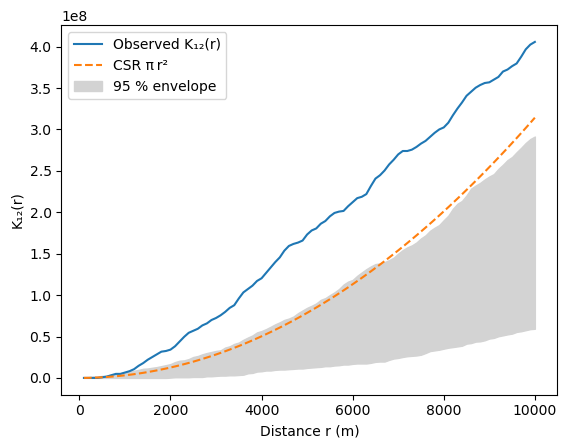

In [14]:
# Define study‐area bounds and area directly from your LGA polygon
lga_gdf = lga
minx, miny, maxx, maxy = lga_gdf.unary_union.bounds
area = lga_gdf.unary_union.area
dr    = 100    # metre increments
r_max = 10000  # test up to 10 km
rs    = np.arange(dr, r_max+dr, dr)
f_pts = np.vstack([flood.geometry.x, flood.geometry.y]).T
d_pts = np.vstack([dams.geometry.x,   dams.geometry.y]).T
#calculate distance matrix
Dmat  = distance_matrix(f_pts, d_pts)
n1, n2       = f_pts.shape[0], d_pts.shape[0]
lambda_dams  = n2 / area
counts_obs   = [(Dmat<=r).sum() for r in rs]
K_obs        = np.array(counts_obs) / (n1 * lambda_dams)
#Build Monte Carlo envelopes (99 random dam‐scatterings)
sims = []
for _ in range(99):
    # randomly re‐scatter dams within Moira’s bounding box
    xs = np.random.uniform(minx, maxx, n2)
    ys = np.random.uniform(miny, maxy, n2)
    Dsim = distance_matrix(f_pts, np.vstack([xs, ys]).T)
    sims.append([(Dsim <= r).sum() for r in rs])

# normalize and extract envelopes
sims = np.array(sims) / (n1 * lambda_dams)
lower = np.percentile(sims,   2.5, axis=0)
upper = np.percentile(sims, 97.5, axis=0)
## plotting k ripley k12 curve
plt.plot(rs, K_obs,      label="Observed K₁₂(r)")
plt.plot(rs, np.pi*rs**2,"--", label="CSR π r²")
plt.fill_between(rs, lower, upper, color="lightgrey", label="95 % envelope")
plt.xlabel("Distance r (m)")
plt.ylabel("K₁₂(r)")
plt.legend()
plt.show()


#### Results and Discussion
Interpretation: 

Observed 
𝐾
12
(
𝑟
)
K 
12
​
 (r) > CSR π r² and above the 95 % envelope for most 
r up to 10 km
there are more flood–dam pairs within any given distance 
𝑟
r than you’d expect if floods and dams were randomly located.

Interpretation: at intermediate scales arounder 6 km, floods and basins are positively associated flood events tend to occur near clusters of dams rather than in dam-poor areas.

Discussion: Again important analysis, but perhaps we need a more zeroed in, zoomed in approach which looks at the flood event's closest dam and gauge the typical pattern present there. 


#### Cross G nearest neighbours 
The cross-nearest-neighbor 
𝐺
12
(
𝑟
)
G 
12
​
 (r) function is a natural complement to Ripley’s 
𝐾
12
(
𝑟
)
K 
12
​
 (r) when you want to zero‐in on each flood point’s closest dam and ask: “How typical (or atypical) is that nearest dam distance compared to random?”

 How we use it in our Moira analysis:
 - Build a KD‐tree of dam points (Reference A2, A3)
 - Compute empirical nearest‐dam distances (Reference A2, A3)
 - Define a sequence of radii and Estimate the observed 
𝐺
12
(
𝑟
)
G 
12
​
 (r)
 - Compute the CSR baseline
 - Build a Monte Carlo envelope

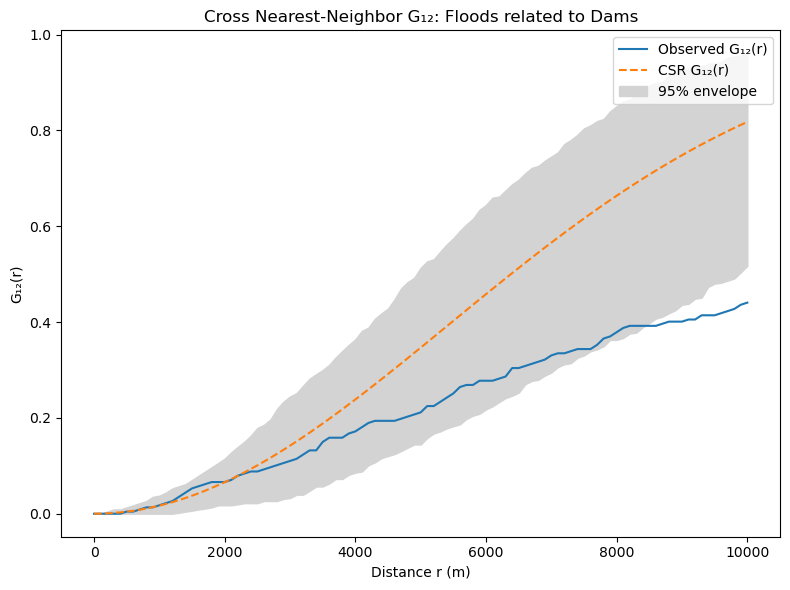

In [15]:
# Convert GeoDataFrames to NumPy arrays of [x, y] for spatial queries
f_pts = np.vstack([flood.geometry.x, flood.geometry.y]).T
d_pts = np.vstack([dams.geometry.x,   dams.geometry.y]).T
# Fast nearest‐neighbor search: for each flood point, find distance to closest dam
tree     = cKDTree(d_pts)
dists, _ = tree.query(f_pts, k=1)  
# 'dists' is an array of length = number of flood points
# We'll evaluate G₁₂(r) from r=0 up to 10 km, in 100 m steps
r_max = 10_000  
dr    = 100     
rs    = np.arange(0, r_max + dr, dr)
# For each r, compute the fraction of flood points whose nearest dam ≤ r
G_obs = np.array([(dists <= r).sum() / len(dists) for r in rs])
# Dam intensity λ₂ = (# dams) / (area of Moira)
minx, miny, maxx, maxy = lga_gdf.unary_union.bounds
area        = lga_gdf.unary_union.area
lambda_dams = len(d_pts) / area
# The null model: G_CSR(r) = 1 − exp(−λ₂·π·r²)
G_theo = 1 - np.exp(-lambda_dams * np.pi * rs**2)
n_sims = 99
G_sims = np.zeros((n_sims, len(rs)))

for i in range(n_sims):
    # randomly scatter the same number of dams inside the LGA
    rand_pts = []
    while len(rand_pts) < len(d_pts):
        x, y = np.random.uniform(minx, maxx), np.random.uniform(miny, maxy)
        if lga_gdf.unary_union.contains(Point(x, y)):
            rand_pts.append((x, y))
    rand_pts = np.array(rand_pts)
    
    # compute nearest‐neighbor distances for that simulation
    tree_rand  = cKDTree(rand_pts)
    d_rand, _  = tree_rand.query(f_pts, k=1)
    
    # build the simulated G₁₂ curve
    G_sims[i] = [(d_rand <= r).sum() / len(d_rand) for r in rs]

# extract the 2.5% and 97.5% quantiles at each r
lower = np.percentile(G_sims, 2.5, axis=0)
upper = np.percentile(G_sims,97.5, axis=0)
# Plotting G12
plt.figure(figsize=(8,6))
plt.plot(rs, G_obs,      label='Observed G₁₂(r)')
plt.plot(rs, G_theo, '--', label='CSR G₁₂(r)')
plt.fill_between(rs, lower, upper, color='lightgrey', label='95% envelope')
plt.xlabel('Distance r (m)')
plt.ylabel('G₁₂(r)')
plt.title('Cross Nearest-Neighbor G₁₂: Floods related to Dams')
plt.legend()
plt.tight_layout()
plt.show()


#### Results and Discussion
Interpretation: 
Observed 
𝐺
12
(
𝑟
)
G 
12
​
 (r) < CSR 
𝐺
12
(
𝑟
)
G 
12
​
 (r) and below the 95 % envelope at nearly all 
𝑟
the fraction of flood points whose nearest dam lies within distance 
𝑟
r is smaller than random.

Interpretation: floods are, on average, further from their closest dam than we would expect by chance evidence of a local protective buffer immediately around each basin. Clearly we see, here it shows floods rarely breach the immediate vicinity of a dam.By running the cross-
𝐺
G we get a direct, scale specific measure of dam effectiveness: it tells us the precise radius within which dams are doing their job of keeping floodwaters away, complementing the broader scale clustering story from Ripley’s 
𝐾
12
(
𝑟
)
K 
12
​
 (r)

**Overall Interpretation from Cross Ripley K and Cross G:**
Local protection vs. catchment clustering:

G₁₂ reveals a protective buffer floods avoid the nearest dam at small distances, indicating each basin shields its immediate surroundings.

K₁₂ uncovers that, beyond that local buffer, flood events and dams co‐locate at broader scales (2–8 km), reflecting the landscape’s catchment structure: dams are sited along rivers and floodplains where flood extents also tend to concentrate.

Multi‐scale insight:

- At 
r<500 m, dam presence suppresses flooding (repulsion in G).

- At 
r=2–8 km, flood occurrences cluster around groups of dams (attraction in K).

Discussion: Cross K and Cross G together help to understand a pattern while alone they might not be able to hold up the hypothesis

## Conclusion
Each dam/retarding basin effectively protects its immediate neighborhood from inundation (no floods within less distance). However, the broader flood areas where most dams are actually we see located still experiences significant flooding, thus perhaps we can say flood events and basins are positively associated at larger distances. This pattern confirms that dam infrastructure is doing their local job but also highlights where perhaps additional mitigation could be helpful (such as more basins) might be needed in the surrounding 1–10 km band to reduce flood impact (esp in case major flooding) across the catchment.

# Overall Conclusion and Reccomendations

In conclusion, through our analysis we see that while Moira’s dam and basin infrastructure does work against the floods in the immediate vicinity of this infrastructure, the wider existence of flood occurrence and extent are driven by natural terrain. As seen above, the low lying and concave depressions tend to have a higher flood extent and would require different solutions for mitigation. Moreover, significant clustering of large extent floods in certain areas tells us that there is need for targeted action based on the above analysis. 

We take a look at the following UN sustainability goals: 
- Sustainable Cities and Communities
- Climate Action 
- Life on Land
- Clean Water and Sanitation 


Taking a look at our analysis, we make the following recommendations for the Moira Council and Victoria government: 
- Since runoff accumulation exists as seen above, we should focus on reforestation at low lying and low slope areas
- Dam infrastructure should be maintained and installed keeping in mind concave depressions and should complement the infrastructure of the existing major dams. 
- As we see that risk flood events and spatial elevation relationship with extent of dams exist, the development and planning should also focus on urban zones at risk and maybe incentive activities such as permeable paving (e.g. porous concrete) and rain gardens 
- Sensors to gather accurate data and consistent rainfall as well as flood reporting will maintain history and pattern of floods that the govt. can keep in check
 

## 10. References & Tools
- Assignment 1/2/3 notes
- Python: geopandas, rasterio, matplotlib, numpy
- Point Pattern Analysis using Cross Ripley K https://doi.org/10.2307/2347952